In [1]:
import os
import sys
import pathlib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL

from scipy.stats import kendalltau

PROJECT_ROOT = os.path.abspath(os.path.join(sys.path[0], os.pardir))
sys.path.append(PROJECT_ROOT)
from src.utils import parse_configargparse_args


/home/amritagupta/.conda/envs/streamflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
site_abbrevs = {
    'Avery_Brook_Bridge_01171000': 'AVERYBB',
    'West_Brook_0_Master_01171100': 'WESTB0',
}
site_folders = {
    'AVERYBB': 'Avery_Brook_Bridge_01171000',
    'WESTB0': 'West_Brook_0_Master_01171100',
}

In [3]:
def convert_col_to_timestamp(dataframe, column):
    dataframe[column] = pd.to_datetime(dataframe[column])
    return dataframe


In [4]:
# search for training run with given parameters
def search_train_runs(run_folder, params, params_file='params.txt'):
    matches = None
    for run in os.listdir(run_folder):
        run_params = parse_configargparse_args(os.path.join(run_folder, run, params_file))
        if all(run_params[k] == v for k, v in params.items()):
            if matches is None:
                matches = []
            matches.append(os.path.join(run_folder, run))
    return matches

## Example
# params = {
#     'site': 'AVERYBB',
#     'num_train_pairs': 5000,
#     'margin': 0.0,
#     'min_month': 1,
#     'max_month': 12,
# }
# train_output_dir = os.path.join(PROJECT_ROOT, 'results', 'train_ranking_model')
# search_train_runs(train_output_dir, params)


In [5]:
# search for inference run with given parameters

def search_inference_runs(
        run_folder, 
        params, 
        inf_params_file='params.pkl', 
        train_params_file='params.txt'
    ):
    """
    Search for inference runs with given parameters
    """    
    # get all inference runs with given parameters
    matches = None
    for run in os.listdir(run_folder):
        inference_run_params = pickle.load(
            open(os.path.join(run_folder, run, inf_params_file), 'rb')
        )
        # check if the inference site matches
        inference_sites = [
            v for k, v in site_abbrevs.items() 
            if k in inference_run_params['inference_data_file']
        ]
        if len(inference_sites) != 1:
            raise ValueError('Inference site could not be determined from inference data file name')
        inference_site = inference_sites[0]
        if inference_site != params['inference_site']:
            continue
        
        # check if the inference checkpoint training parameters match
        inference_ckpt_train_output_dir = inference_run_params['train_output_dir']
        inference_ckpt_train_params = {'warm_start_from_checkpoint': None}
        inference_ckpt_train_params.update(
            parse_configargparse_args(
                os.path.join(inference_ckpt_train_output_dir, train_params_file)
            )
        )
        if inference_ckpt_train_params['warm_start_from_checkpoint'] != params['inference_checkpoint']['warm_start_from_checkpoint']:
            continue

        # check warm start checkpoint training parameters if needed
        if inference_ckpt_train_params['warm_start_from_checkpoint'] is not None:
            ckpt_file = inference_ckpt_train_params['warm_start_from_checkpoint']
            warm_start_ckpt_train_output_dir = pathlib.Path(ckpt_file).parent.parent
            warm_start_ckpt_train_params = {'warm_start_from_checkpoint': None}
            warm_start_ckpt_train_params.update(
                parse_configargparse_args(
                    os.path.join(warm_start_ckpt_train_output_dir, train_params_file)
                )
            )
            inference_ckpt_train_params['warm_start_from_checkpoint'] = {
                k: v for k, v in warm_start_ckpt_train_params.items()
                if k in params['inference_checkpoint']['warm_start_from_checkpoint']
            }
        
        if all([
            inference_ckpt_train_params[k] == v
            for k, v in params['inference_checkpoint'].items()
        ]):
            if matches is None:
                matches = []
            matches.append(os.path.join(run_folder, run))
    
    return matches



In [6]:
params = {
    'inference_site': 'WESTB0',
    'inference_checkpoint': {
        'site': 'WESTB0',
        'num_train_pairs': 5000,
        'margin': 0.0,
        # 'min_month': 4,
        # 'max_month': 11,
        'min_month': 1,
        'max_month': 12,
        'min_hour': 7,
        'max_hour': 18,
        # 'min_hour': 0,
        # 'max_hour': 23,
        'warm_start_from_checkpoint': None
        # 'warm_start_from_checkpoint': {
        #     'site': 'WESTB0',
        #     'num_train_pairs': 5000,
        #     'margin': 0.0,
        #     'min_month': 4,
        #     'max_month': 11,
        #     'min_hour': 7,
        #     'max_hour': 18,
        # }
    }
}
inference_output_dir = os.path.join(PROJECT_ROOT, 'results', 'inference_ranking_model')
matched_inference_runs = search_inference_runs(inference_output_dir, params)
matched_inference_runs

['/home/amritagupta/ssdprivate/repos/fpe-model/results/inference_ranking_model/inference_ranking_model_17']

In [7]:
print(matched_inference_runs[0])
preds = pd.read_csv(
    os.path.join(matched_inference_runs[0], 'inference_results_flow-images.csv')
)
preds = convert_col_to_timestamp(preds, 'timestamp')
preds['ranked_flow_cfs'] = preds['flow_cfs'].rank(pct=True)
preds['ranked_score'] = preds['scores'].rank(pct=True)
preds['smoothed_ranked_score'] = preds['ranked_score'].rolling(10).mean()


inf_run_params = pickle.load(open(os.path.join(matched_inference_runs[0], 'params.pkl'), 'rb'))
train_data = pd.read_csv(os.path.join(inf_run_params['train_output_dir'], 'train_data.csv'))
val_data = pd.read_csv(os.path.join(inf_run_params['train_output_dir'], 'val_data.csv'))
test_data = pd.read_csv(os.path.join(inf_run_params['train_output_dir'], 'test_data.csv'))

# Check if train, val, test data are disjoint
assert len(test_data[test_data['filename'].isin(train_data['filename'])]) == 0, "Test data contains train data"
assert len(test_data[test_data['filename'].isin(val_data['filename'])]) == 0, "Test data contains val data"
# TODO: also check if test data overlaps with any warmstart model training data

# Evaluate Kendall Tau on train, val, test, and other data
preds_train = preds[preds['filename'].isin(train_data['filename'])].copy()
preds_val = preds[preds['filename'].isin(val_data['filename'])].copy()
preds_test = preds[preds['filename'].isin(test_data['filename'])].copy()
preds_other = preds[
    (preds['filename'].isin(train_data['filename']) == False) &
    (preds['filename'].isin(val_data['filename']) == False) &
    (preds['filename'].isin(test_data['filename']) == False)
].copy()
train_kt = kendalltau(preds_train['flow_cfs'], preds_train['scores'])
val_kt = kendalltau(preds_val['flow_cfs'], preds_val['scores'])
test_kt = kendalltau(preds_test['flow_cfs'], preds_test['scores'])
other_kt = kendalltau(preds_other['flow_cfs'], preds_other['scores'])
print('Train Kendall Tau: {:.3f}'.format(train_kt.correlation))
print('Val Kendall Tau: {:.3f}'.format(val_kt.correlation))
print('Test Kendall Tau: {:.3f}'.format(test_kt.correlation))
print('Other Kendall Tau: {:.3f}'.format(other_kt.correlation))

# Evaluate other data sliced by daytime/nighttime and winter/non-winter
# ckpt_train_params = parse_configargparse_args(os.path.join(inf_run_params['train_output_dir'], 'params.txt'))

preds_other_nighttime_winter = preds_other[
    ~preds_other['timestamp'].dt.hour.between(7, 18) &
    ~preds_other['timestamp'].dt.month.between(4, 11)
]
other_nighttime_winter_kt = kendalltau(preds_other_nighttime_winter['flow_cfs'], preds_other_nighttime_winter['scores'])
print('Other Nighttime Winter Kendall Tau: {:.3f}'.format(other_nighttime_winter_kt.correlation))

preds_other_daytime_winter = preds_other[
    preds_other['timestamp'].dt.hour.between(7, 18) &
    ~preds_other['timestamp'].dt.month.between(4, 11)
]
other_daytime_winter_kt = kendalltau(preds_other_daytime_winter['flow_cfs'], preds_other_daytime_winter['scores'])
print('Other Daytime Winter Kendall Tau: {:.3f}'.format(other_daytime_winter_kt.correlation))

preds_other_nighttime_nonwinter = preds_other[
    ~preds_other['timestamp'].dt.hour.between(7, 18) &
    preds_other['timestamp'].dt.month.between(4, 11)
]
other_nighttime_nonwinter_kt = kendalltau(preds_other_nighttime_nonwinter['flow_cfs'], preds_other_nighttime_nonwinter['scores'])
print('Other Nighttime Non-Winter Kendall Tau: {:.3f}'.format(other_nighttime_nonwinter_kt.correlation))

/home/amritagupta/ssdprivate/repos/fpe-model/results/inference_ranking_model/inference_ranking_model_17
Train Kendall Tau: 0.904
Val Kendall Tau: 0.652
Test Kendall Tau: 0.858
Other Kendall Tau: 0.881
Other Nighttime Winter Kendall Tau: 0.701
Other Daytime Winter Kendall Tau: nan
Other Nighttime Non-Winter Kendall Tau: 0.889


In [33]:
def plot_image_grid(images, n_col=5, figsize=(25, 25), show=True):
    n_row = len(images) // n_col
    if len(images) % n_col != 0:
        n_row += 1
    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image)
        ax.axis("off")
    if show:
        plt.show()
    return fig, axes

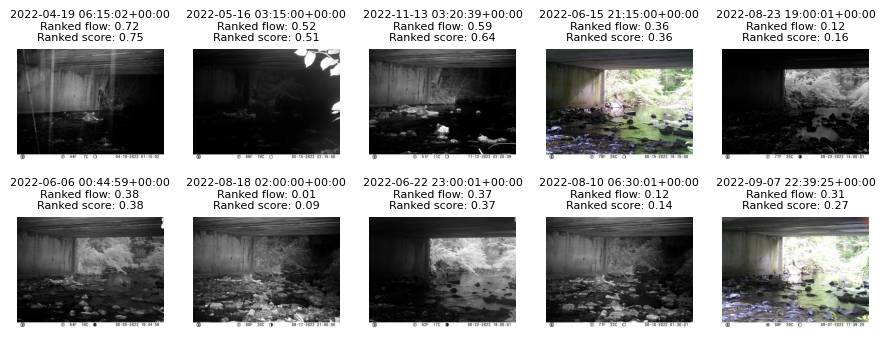

In [45]:
nighttime_nonwinter_indices = np.random.choice(preds_other_nighttime_nonwinter.index, 10, replace=False)
nighttime_nonwinter_fnames = [
    os.path.join('../data/raw', site_folders[params['inference_site']], 'images', fname)
    for fname in preds_other_nighttime_nonwinter.loc[nighttime_nonwinter_indices, 'filename'].values
]
nighttime_nonwinter_images = [
    np.asarray(PIL.Image.open(fname))
    for fname in nighttime_nonwinter_fnames
]
nighttime_nonwinter_titles = [
    f'{preds_other_nighttime_nonwinter.loc[idx, "timestamp"]}\nRanked flow: {preds_other_nighttime_nonwinter.loc[idx, "ranked_flow_cfs"]:.2f}\nRanked score: {preds_other_nighttime_nonwinter.loc[idx, "ranked_score"]:.2f}'
    for idx in nighttime_nonwinter_indices
]
fig, axes = plot_image_grid(nighttime_nonwinter_images, figsize=(11, 4), show=False)
for ax, title in zip(axes.flatten(), nighttime_nonwinter_titles):
    ax.set_title(title, fontsize=8)

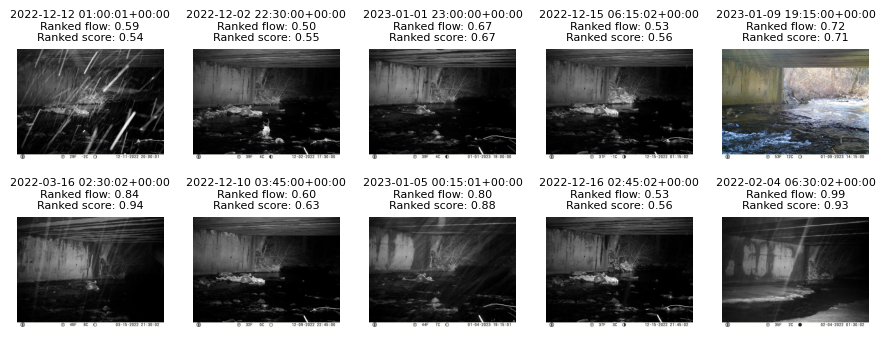

In [46]:
nighttime_winter_indices = np.random.choice(preds_other_nighttime_winter.index, 10, replace=False)
nighttime_winter_fnames = [
    os.path.join('../data/raw', site_folders[params['inference_site']], 'images', fname)
    for fname in preds_other_nighttime_winter.loc[nighttime_winter_indices, 'filename'].values
]
nighttime_winter_images = [
    np.asarray(PIL.Image.open(fname))
    for fname in nighttime_winter_fnames
]
nighttime_winter_titles = [
    f'{preds_other_nighttime_winter.loc[idx, "timestamp"]}\nRanked flow: {preds_other_nighttime_winter.loc[idx, "ranked_flow_cfs"]:.2f}\nRanked score: {preds_other_nighttime_winter.loc[idx, "ranked_score"]:.2f}'
    for idx in nighttime_winter_indices
]
fig, axes = plot_image_grid(nighttime_winter_images, figsize=(11, 4), show=False)
for ax, title in zip(axes.flatten(), nighttime_winter_titles):
    ax.set_title(title, fontsize=8)

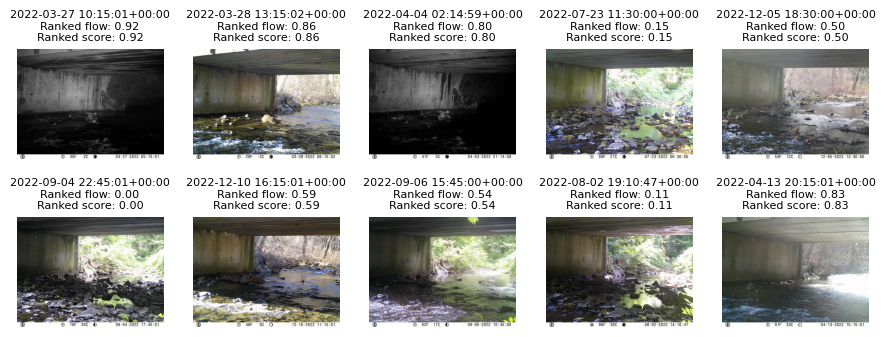

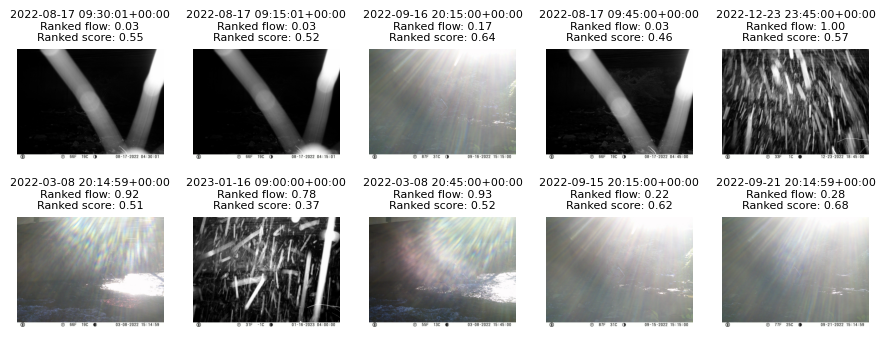

In [47]:
preds['rank_diff'] = np.abs(preds['ranked_flow_cfs'] - preds['ranked_score'])

# good agreement
good_agreement_indices = preds['rank_diff'].sort_values(ascending=False).tail(10).index
good_agreement_fnames = [
    os.path.join('../data/raw', site_folders[params['inference_site']], 'images', fname)
    for fname in preds.loc[good_agreement_indices, 'filename'].values
]
good_agreement_images = [
    np.asarray(PIL.Image.open(fname))
    for fname in good_agreement_fnames
]
good_agreement_titles = [
    f'{preds.loc[idx, "timestamp"]}\nRanked flow: {preds.loc[idx, "ranked_flow_cfs"]:.2f}\nRanked score: {preds.loc[idx, "ranked_score"]:.2f}'
    for idx in good_agreement_indices
]
fig, axes = plot_image_grid(good_agreement_images, figsize=(11, 4), show=False)
for ax, title in zip(axes.flatten(), good_agreement_titles):
    ax.set_title(title, fontsize=8)

# bad agreement
bad_agreement_indices = preds['rank_diff'].sort_values(ascending=False).head(10).index
bad_agreement_fnames = [
    os.path.join('../data/raw', site_folders[params['inference_site']], 'images', fname)
    for fname in preds.loc[bad_agreement_indices, 'filename'].values
]
bad_agreement_images = [
    np.asarray(PIL.Image.open(fname))
    for fname in bad_agreement_fnames
]
bad_agreement_titles = [
    f'{preds.loc[idx, "timestamp"]}\nRanked flow: {preds.loc[idx, "ranked_flow_cfs"]:.2f}\nRanked score: {preds.loc[idx, "ranked_score"]:.2f}'
    for idx in bad_agreement_indices
]
fig, axes = plot_image_grid(bad_agreement_images, figsize=(11, 4), show=False)
for ax, title in zip(axes.flatten(), bad_agreement_titles):
    ax.set_title(title, fontsize=8)

In [39]:
colors = [
    '#e69f00',
    '#56b4e9',
    '#009e73',
    '#f0e442',
    '#0072b2',
    '#d55e00',
    '#cc79a7',
    '#000000'
]

def plot_timeseries_with_gaps(ax, dataframe, x_col, y_col, c='blue', linestyle='-', gap_threshold=15, gap_units='m', alpha=1, label=None):
    xy_data = dataframe[[x_col, y_col]].set_index(x_col).squeeze(axis=1)
    gaps = np.flatnonzero(np.diff(xy_data.index) > np.timedelta64(gap_threshold, gap_units))
    if gap_units == 'D':
        xy_data_aug = pd.concat([xy_data, pd.Series(index=xy_data.index[gaps] + np.timedelta64(gap_threshold, gap_units).item().days, dtype=float)])
    else:
        xy_data_aug = pd.concat([xy_data, pd.Series(index=xy_data.index[gaps] + np.timedelta64(gap_threshold, gap_units), dtype=float)])
    xy_data_aug.sort_index(inplace=True)
    ax.plot(xy_data_aug, c=c, alpha=alpha, linestyle=linestyle, label=label)

def scatter_plot(ax, dataframe, x_col, y_col, c='blue', alpha=1, s=5, label=None):
    ax.scatter(dataframe[x_col], dataframe[y_col], c=c, alpha=alpha, s=5, label=label)



In [40]:
preds.head(3)

,Unnamed: 0,station_name,station_id,imageset_id,image_id,timestamp,filename,url,flow_cfs,scores,ranked_flow_cfs,ranked_score,smoothed_ranked_score
0,0,West Brook 0_01171100,29,289,441411,2022-02-01 18:00:00+00:00,West Brook Master__2022-02-01__13-00-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,4.71,6.171982,0.436914,0.564468,NaN
1,1,West Brook 0_01171100,29,289,441412,2022-02-01 18:15:00+00:00,West Brook Master__2022-02-01__13-15-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,4.71,6.910850,0.436914,0.592833,NaN
2,2,West Brook 0_01171100,29,289,441413,2022-02-01 18:30:00+00:00,West Brook Master__2022-02-01__13-30-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,4.71,6.229506,0.436914,0.566874,NaN


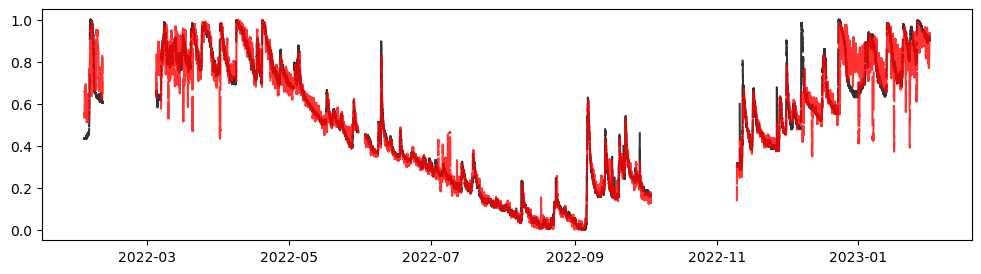

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
plot_timeseries_with_gaps(ax, preds, 'timestamp', 'ranked_flow_cfs', c=colors[-1], alpha=0.8)
plot_timeseries_with_gaps(ax, preds, 'timestamp', 'smoothed_ranked_score', c='red', alpha=0.8)